In [2]:
import math
import numpy as np

In [38]:
import matplotlib.pyplot as plt

In [33]:
from click import group
from torch import norm


def sample_uniform(a, b, sample_size):
    """
    Generates a uniform distribution of samples between a and b.
    
    Parameters:
    a (float): Lower bound of the dist.
    b (float): Upper bound of the dist.
    sample_size (int): Number of samples to generate.

    returns:
    List of floats: Generated samples.
    """
    return [a + (b-a) * np.random.rand() for _ in range(sample_size)]


def sample_gaussian(mu, sigma, sample_size):
    """
    Generates a gaussian distribution of samples with mean as mu and standard deviation as sigma.

    Parameters:
    mu (float): Mean of the dist.
    sigma (float): Standard deviation of the dist.
    sample_size (int): Number of samples to generate.

    returns:
    List of floats: Generated samples.
    """
    samples = []
    while len(samples) < sample_size:
        u1, u2 = np.random.rand(), np.random.rand()
        r = math.sqrt(-2 * math.log(u1))
        theta = 2 * math.pi * u2
        z0, z1 = r * math.cos(theta), r * math.sin(theta)
        samples.extend([mu + sigma * z0, mu + sigma * z1])
    return samples[:sample_size]


def sample_2d_gaussian(mu_2d, sigma_2d, sample_size):
    """
    Generates a 2D gaussian distribution of samples with mean as mu_2d and standard deviation as sigma_2d.

    Parameters:
    mu_2d (tuple): Mean of the dist as (mu_x, mu_y).
    sigma_2d (tuple): Standard deviation of the dist as (sigma_x, sigma_y).
    sample_size (int): Number of samples to generate.

    returns:
    List of tuples: Generated samples as (x, y).
    """
    samples = []
    L = np.linalg.cholesky(sigma_2d)
    for _ in range(sample_size):
        z = np.array([sample_gaussian(0, 1, 1)[0], sample_gaussian(0, 1, 1)[0]])
        x = mu_2d + L @ z
        samples.append(x)
    return np.array(samples)


def stevens_sampling(pmf, N=20, tol=1e-2, group_size=10):
    """
    Uses Stevens sampling method to sample from a discrete non uniform distribution without replacement.
    The intuition behind this method is to form groups of of probabilities after ordering the pmf in descending order.
    Then we sample these groups based on their average probilities.
    An element from this group is selected as though it is a uniform distribution.
    The process is repeated until the sample size is reached.
    """
    M = len(pmf)
    pmf = np.array(pmf)
    assert math.isclose(np.sum(pmf), 1.0, abs_tol=1e-4), "Probabilities must sum to 1"
    sorted_indices = pmf.argsort()[::-1]

    groups = {}
    for i in range(0, M, group_size):
        group_id = i // group_size
        group_indices = sorted_indices[i: i + group_size]
        groups[group_id] = np.array(list(group_indices))
    
    avg_prob_of_groups = {grp: np.mean(pmf[means]) for grp, means in groups.items()}
    groups_pmf = np.array(list(avg_prob_of_groups.values()))
    groups_pmf /= np.sum(groups_pmf)
    print(np.sum(groups_pmf))
    selected_indices = list()

    while len(selected_indices) < N:
        selected_group = np.random.choice(list(groups.keys()), p=groups_pmf)
        if len(groups[selected_group]) == 0:
            raise ValueError("Not enough elements to sample from")
        selected_index = np.random.choice(groups[selected_group])
        while selected_index in selected_indices:
            selected_index = np.random.choice(groups[selected_group])
        selected_indices.append(selected_index)
        print(f"Selected group: {selected_group}, selected index: {selected_index}")
        groups[selected_group] = [i for i in groups[selected_group] if i not in selected_indices]
    
    return selected_indices



In [35]:
print("Uniform Samples:", sample_uniform(0, 10, 5))
print("Gaussian Samples:", sample_gaussian(0, 1, 5))

mu_2d = np.array([0, 0])
sigma_2d = np.array([[1, 0.5], [0.5, 1]])
print("2D Gaussian Samples:", sample_2d_gaussian(mu_2d, sigma_2d, 5))

M = 300
N = 20
pmf = np.random.rand(M)
pmf /= sum(pmf)  # Normalize the pmf
print("Discrete Without Replacement:", stevens_sampling(pmf, N))

pmf = np.random.rand(M - 10)
pmf /= np.sum(pmf)
scaled_pmf = pmf * 0.6

pmf2 = np.random.rand(10)
pmf2 /= np.sum(pmf2)
pmf2 = pmf2 * 0.4
pmf = np.concatenate((pmf2, scaled_pmf))
print("Discrete Without Replacement:", stevens_sampling(pmf, N))


Uniform Samples: [7.579405790224513, 2.5512067306190946, 5.509504568816288, 5.9104204172478205, 6.352623889118737]
Gaussian Samples: [-0.08903015852969767, -1.7823123534872238, 0.9266606353075763, 0.14763015809184538, -0.41897689450882825]
2D Gaussian Samples: [[ 0.14346735  0.7023988 ]
 [-2.37205976  0.36174589]
 [-1.41702161 -0.26003744]
 [ 0.83570417  0.88728073]
 [ 0.80283682  1.81385107]]
1.0000000000000002
Selected group: 12, selected index: 5
Selected group: 22, selected index: 138
Selected group: 6, selected index: 230
Selected group: 13, selected index: 268
Selected group: 8, selected index: 270
Selected group: 5, selected index: 179
Selected group: 5, selected index: 208
Selected group: 9, selected index: 154
Selected group: 11, selected index: 75
Selected group: 12, selected index: 272
Selected group: 4, selected index: 51
Selected group: 7, selected index: 16
Selected group: 7, selected index: 194
Selected group: 4, selected index: 93
Selected group: 0, selected index: 193


### Rejection sampling

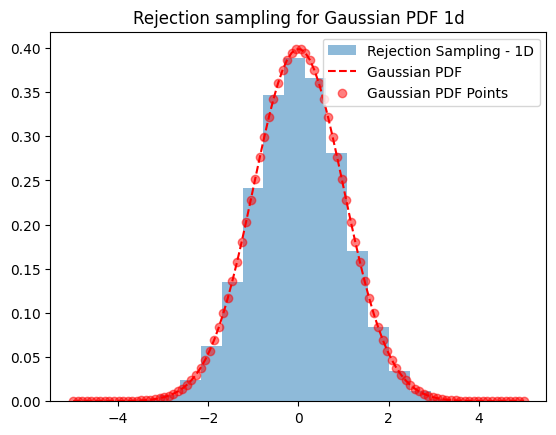

In [48]:


def gaussian_pdf(x, mu=0, sigma=1):
    """
    Computes the probability density function of a Gaussian distribution.
    
    Parameters:
    x - the point at which to evaluate the PDF
    mu - mean of the dist
    sigma - standar dev of the dist.
    By default we are using a standard normal dist.
    
    Returns:
    Probability at x.
    """
    coeff =  1 / (np.sqrt(2 * np.pi) * sigma ** 2)
    exponent_part = np.exp(-0.5 * (((x - mu) ** 2) / (sigma ** 2)))
    return coeff * exponent_part


def rejection_sampling_for_gaussian_1d(sample_size, L=5, mu=0, sigma=1):
    """
    Generates samples from a Gaussian distribution using rejection sampling.
    The idea is to sample from a uniform distribution (the propsal distribution) and then accept or reject the samples based on the Gaussian PDF.
    The target distribution is a standard normal distribution.
    The proposal distribution is a uniform distribution.
    The proposal dist extends from -L t- L.
    The proposal distribution is scaled by a factor of M which is the maximum value of the target distribution.

    u ~ U(0, 1)
    x ~ U(-L, L)
    y ~ N(mu, sigma)
    u <= f(x) / M g(x)

    Parameters:
    sample_size - number of samples to generate.
    L - the length of the proposal distribution.

    Returns:
    List of samples from the Gaussian distribution.
    """
    samples = []
    g_x = 1 / (2 * L)
    f_max = gaussian_pdf(mu, mu, sigma)
    M = f_max / g_x

    while len(samples) < sample_size:
        x = np.random.uniform(-L, L)
        u = np.random.rand()
        y = gaussian_pdf(x, mu, sigma)
        if u <= y / (M * g_x):
            samples.append(x)

    return samples


samples = rejection_sampling_for_gaussian_1d(100000, L=5, mu=0, sigma=1)
plt.hist(samples, bins=20, density=True, alpha=0.5, label="Rejection Sampling - 1D")
x = np.linspace(-5, 5, 100)
plt.plot(x, gaussian_pdf(x), "r--", label="Gaussian PDF")
plt.scatter(x, gaussian_pdf(x), color="red", alpha=0.5, label="Gaussian PDF Points")
plt.legend()
plt.title("Rejection sampling for Gaussian PDF 1d")
plt.show()

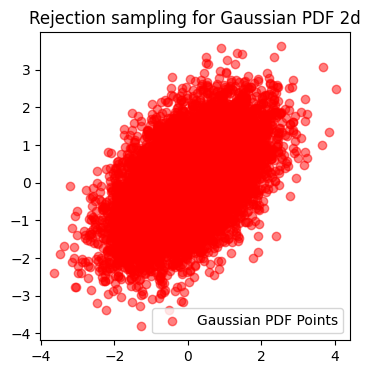

In [57]:
def gaussian_pdf_2d(x, y, mu, sigma):
    """
    Computes the probability density function of a 2D Gaussian distribution.
    """

    # mu_x,  mu_y = mu
    # sigma_x, sigma_y = sigma

    # coeff = 1 / (2 * np.pi * sigma_x * sigma_y)
    # exponent_part = np.exp(-0.5 * ((x - mu_x) ** 2 / sigma_x ** 2 + (y - mu_y) ** 2 / sigma_y ** 2))
    mu = np.array(mu)
    cov = np.array(sigma)

    det = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    coeff = 1 / (2 * np.pi * np.sqrt(det))
    exponent_part = np.exp(-0.5 * ((np.array([x, y]) - mu).T @ inv_cov @ (np.array([x, y]) - mu)))
    return coeff * exponent_part


def rejection_sampling_for_gaussian_2d(sample_size, L=5, mu=(0, 0), sigma=(1, 1)):
    samples = []

    g_xy = 1 /(4 * L * L)
    f_max = gaussian_pdf_2d(mu[0], mu[1], mu, sigma)
    M = f_max / g_xy

    while len(samples) < sample_size:
        x = np.random.uniform(-L, L)
        y = np.random.uniform(-L, L)
        u = np.random.rand()
        f_x = gaussian_pdf_2d(x, y, mu, sigma)
        if u <= f_x / (M * g_xy):
            samples.append(np.array([x, y]))

    return np.array(samples)

samples = rejection_sampling_for_gaussian_2d(10000, L=5, mu=[0, 0], sigma=[[1, 0.5], [0.5, 1]])

plt.figure(figsize=(4, 4))
plt.scatter(samples[:, 0], samples[:, 1], color="red", alpha=0.5, label="Gaussian PDF Points")
plt.legend()
plt.title("Rejection sampling for Gaussian PDF 2d")
plt.show()